In [ ]:
#%matplotlib qt

In [1]:
%matplotlib notebook
%matplotlib inline
%autosave 120

Autosaving every 120 seconds


In [61]:
import os

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from pandarallel import pandarallel

import multiprocessing as mp

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
from microsim.bp_treatment_strategies import *

from microsim.outcome_model_repository import OutcomeModelRepository
from microsim.outcome_model_type import OutcomeModelType
from microsim.person import Person

from microsim.population import NHANESDirectSamplePopulation

from microsim.bp_treatment_strategies import SprintTreatment

from microsim.sim_settings import simSettings

from microsim.trials.trialset import TrialsetParallel, TrialsetSerial
from microsim.trials.trial_description import TrialDescription
from microsim.trials.logistic_regression_analysis import LogisticRegressionAnalysis
from microsim.trials.linear_regression_analysis import LinearRegressionAnalysis
from microsim.trials.outcome_assessor import OutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AttributeOutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AssessmentMethod
from microsim.trials.risk_filter import RiskFilter
from microsim.trials.trial_utils import get_analysis_name, randomizationSchema

In [5]:
#any microsim dir will work, just need to access the NHANES data
#microsimDir = "/users/PAS2164/deligkaris/MICROSIM/CODE/microsim"
microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)
imputedDataset = pd.read_stata(microsimDir + "/microsim/data/fullyImputedDataset.dta")
dataDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/NOTEBOOKS/DATA"

In [6]:
#read the quantiles found in cvDementiaQuantiles.ipynb
#quantilesToInclude = pd.read_csv(dataDir + "/dementiaAndCVQuantilesToInclude.csv",index_col=0)
quantiles = pd.read_csv(dataDir + "/dementiaAndCVQuantileThresholds.csv",index_col=0)

In [7]:
#inputDemThresholds=[]
#inputCvThresholds=[]
#for i,j in quantilesToInclude[["demRisk","cvRisk"]].iterrows():
#    inputDemThresholds.append(quantiles.iloc[j["demRisk"]]["dementia"])
#    inputCvThresholds.append(quantiles.iloc[j["cvRisk"]]["cv"])

In [8]:
#quantilesToInclude.head()

In [9]:
#at the beginning turn on pandarallel if you are planning to use TrialsetSerial
pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = True #with this flag all new population instances will be set to use pandarallel

In [10]:
%%time
# 1.5 hours 150,000 pop and 20 years
# 4 hours 150k pop and 200 years
popSprint = NHANESDirectSamplePopulation(150000, 1999)
popSprint.set_bp_treatment_strategy(SprintTreatment())
aliveSprint, dfSprint = popSprint.advance_vectorized(200)

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/Clou

/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993**x.age
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constan

/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993**x.age
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constan

/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS


/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS


/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS


/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS


CPU times: user 3h 3min 12s, sys: 12min 14s, total: 3h 15min 27s
Wall time: 3h 50min 18s


/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS


In [11]:
%%time
# 1 hour 10 min 150,000 and 20 years
# 3 hours 15 min 150k pop and 200 years
popUsual = NHANESDirectSamplePopulation(150000, 1999)
#popUsual.set_bp_treatment_strategy(SprintTreatment())
aliveUsual, dfUsual = popUsual.advance_vectorized(200)

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993**x.age
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold)

CPU times: user 1h 56min 4s, sys: 15min 1s, total: 2h 11min 5s
Wall time: 3h 3min 2s


In [12]:
def getDFForPersonCol(person):
    df = pd.DataFrame(person.get_final_wave_state_as_dict())
    df['dfIndex'] = person.dfIndex
    df['cvRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person, 
                            args=(OutcomeModelType.CARDIOVASCULAR, 1, True), axis='columns')
    df['demRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person,  
                             args=(OutcomeModelType.DEMENTIA, 1, True), axis='columns')
    return df

dfsUsual = popUsual._people.apply(getDFForPersonCol)
dfsSprint = popSprint._people.apply(getDFForPersonCol)

In [13]:
allAgesUsualDF = pd.concat(dfsUsual.tolist())
allAgesSprintDF = pd.concat(dfsSprint.tolist())

In [14]:
#save dataframes!
#allAgesUsualDF.to_csv(dataDir + "/allAgesUsualDF.csv")

#allAgesSprintDF.to_csv(dataDir + "/allAgesSprintDF.csv")

In [ ]:
#read dataframes with results
#allAgesUsualDF = pd.read_csv(dataDir + "/allAgesUsualDF.csv")

#allAgesSprintDF = pd.read_csv(dataDir + "/allAgesSprintDF.csv")

This is an approach based on person-years

In [22]:
#quantiles

In [15]:
#remove rows that represent the year the person died because the get_final_wave_state_as_dict function
#returns their age for that year to be -1 and that significantly distors their risks
allAgesUsualDF = allAgesUsualDF.loc[allAgesUsualDF["alive"]==True]
allAgesSprintDF = allAgesSprintDF.loc[allAgesSprintDF["alive"]==True]

In [16]:
#this data is now cut in bins based on quantiles developed in the cvDementiaQuantiles notebook
allAgesUsualDF['demRiskQuantile'] = pd.cut(allAgesUsualDF["demRisk"],quantiles["dementia"])
allAgesUsualDF['cvRiskQuantile'] = pd.cut(allAgesUsualDF["cvRisk"],quantiles["cv"])

allAgesSprintDF['demRiskQuantile'] = pd.cut(allAgesSprintDF["demRisk"],quantiles["dementia"])
allAgesSprintDF['cvRiskQuantile'] = pd.cut(allAgesSprintDF["cvRisk"],quantiles["cv"])

In [17]:
allAgesUsualDF['demRiskQuantile'].isna().sum(), allAgesUsualDF['cvRiskQuantile'].isna().sum()

(4770, 0)

In [18]:
allAgesSprintDF['demRiskQuantile'].isna().sum(), allAgesSprintDF['cvRiskQuantile'].isna().sum()

(4840, 0)

In [19]:
#setting these high risks to a maximum of 1 solves the problem
#allAgesUsualDF.loc[allAgesUsualDF["demRisk"]>1]
allAgesUsualDF.loc[allAgesUsualDF.demRisk > 1, 'demRisk'] = 1
allAgesSprintDF.loc[allAgesSprintDF.demRisk > 1, 'demRisk'] = 1

In [26]:
#re-do the cut
allAgesUsualDF['demRiskQuantile'] = pd.cut(allAgesUsualDF["demRisk"],quantiles["dementia"])
allAgesUsualDF['cvRiskQuantile'] = pd.cut(allAgesUsualDF["cvRisk"],quantiles["cv"])

allAgesSprintDF['demRiskQuantile'] = pd.cut(allAgesSprintDF["demRisk"],quantiles["dementia"])
allAgesSprintDF['cvRiskQuantile'] = pd.cut(allAgesSprintDF["cvRisk"],quantiles["cv"])

In [27]:
#there should not be any nans
(allAgesUsualDF['demRiskQuantile'].isna().sum(), allAgesUsualDF['cvRiskQuantile'].isna().sum(),
allAgesSprintDF['demRiskQuantile'].isna().sum(), allAgesSprintDF['cvRiskQuantile'].isna().sum())

(0, 0, 0, 0)

In [28]:
#drop rows with NAN (I think changing the lowest quantile to 0 creates issues at some point)
#allAgesUsualDF = allAgesUsualDF.loc[~allAgesUsualDF['demRiskQuantile'].isna()]
#allAgesUsualDF = allAgesUsualDF.loc[~allAgesUsualDF['cvRiskQuantile'].isna()]

#allAgesSprintDF = allAgesSprintDF.loc[~allAgesSprintDF['demRiskQuantile'].isna()]
#allAgesSprintDF = allAgesSprintDF.loc[~allAgesSprintDF['cvRiskQuantile'].isna()]

In [29]:
#these are the same for both usual and sprint, the quantile intervals were simply read in this notebook
#they were created in cvDementiaQuantiles
demQuantileNumberForQuantile = {quantile : index for index, quantile in 
                                enumerate(allAgesUsualDF['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileNumberForQuantile = {quantile : index for index, quantile in 
                               enumerate(allAgesUsualDF['cvRiskQuantile'].value_counts(sort=False).index)}

allAgesUsualDF['cvQuantileNum'] = allAgesUsualDF['cvRiskQuantile']
allAgesUsualDF['cvQuantileNum'].replace(cvQuantileNumberForQuantile, inplace=True)

allAgesUsualDF['demQuantileNum'] = allAgesUsualDF['demRiskQuantile']
allAgesUsualDF['demQuantileNum'].replace(demQuantileNumberForQuantile, inplace=True)

allAgesSprintDF['cvQuantileNum'] = allAgesSprintDF['cvRiskQuantile']
allAgesSprintDF['cvQuantileNum'].replace(cvQuantileNumberForQuantile, inplace=True)

allAgesSprintDF['demQuantileNum'] = allAgesSprintDF['demRiskQuantile']
allAgesSprintDF['demQuantileNum'].replace(demQuantileNumberForQuantile, inplace=True)

In [30]:
#find out how many person-years included dementia (for each quantile-quantile)
countByDementiaUsual = allAgesUsualDF.loc[allAgesUsualDF["dementia"]==True].groupby(
                                ['demQuantileNum', 'cvQuantileNum'],sort=True
                                )["dementia"].count().unstack(fill_value=0).stack()

countByDementiaDFUsual = pd.DataFrame({'demRisk' : countByDementiaUsual.index.get_level_values("demQuantileNum"),
                              'cvRisk' : countByDementiaUsual.index.get_level_values("cvQuantileNum"),
                              'demCount' : countByDementiaUsual.values})

countByDementiaSprint = allAgesSprintDF.loc[allAgesSprintDF["dementia"]==True].groupby(
                                ['demQuantileNum', 'cvQuantileNum'],sort=True
                                )["dementia"].count().unstack(fill_value=0).stack()

countByDementiaDFSprint = pd.DataFrame({'demRisk' : countByDementiaSprint.index.get_level_values("demQuantileNum"),
                              'cvRisk' : countByDementiaSprint.index.get_level_values("cvQuantileNum"),
                              'demCount' : countByDementiaSprint.values})

In [31]:
#find out how many person-years included MI (for each quantile-quantile)
countByMIUsual = allAgesUsualDF.loc[allAgesUsualDF["mi"]==True].groupby(
                                ['cvQuantileNum', 'demQuantileNum'],sort=True
                                )["mi"].count().unstack(fill_value=0).stack()

countByMIDFUsual = pd.DataFrame({'demRisk' : countByMIUsual.index.get_level_values("demQuantileNum"),
                              'cvRisk' : countByMIUsual.index.get_level_values("cvQuantileNum"),
                              'miCount' : countByMIUsual.values})

countByMISprint = allAgesSprintDF.loc[allAgesSprintDF["mi"]==True].groupby(
                                ['cvQuantileNum', 'demQuantileNum'],sort=True
                                )["mi"].count().unstack(fill_value=0).stack()

countByMIDFSprint = pd.DataFrame({'demRisk' : countByMISprint.index.get_level_values("demQuantileNum"),
                              'cvRisk' : countByMISprint.index.get_level_values("cvQuantileNum"),
                              'miCount' : countByMISprint.values})

In [32]:
#find out how many person-years included outcome (for each quantile-quantile)
#outcome is defined as MI or dementia or stroke
countByOutcomeUsual = allAgesUsualDF.loc[ (allAgesUsualDF["mi"]==True) |
                                          (allAgesUsualDF["dementia"]==True) |
                                          (allAgesUsualDF["stroke"]==True) 
                                        ].groupby(
                                ['demQuantileNum', 'cvQuantileNum'],sort=True
                                )["mi"].count().unstack(fill_value=0).stack()#"mi":irrelevant,just needs to be 1column

countByOutcomeDFUsual = pd.DataFrame({'demRisk' : countByOutcomeUsual.index.get_level_values("demQuantileNum"),
                              'cvRisk' : countByOutcomeUsual.index.get_level_values("cvQuantileNum"),
                              'outcomeCount' : countByOutcomeUsual.values})

countByOutcomeSprint = allAgesSprintDF.loc[ (allAgesSprintDF["mi"]==True) |
                                            (allAgesSprintDF["dementia"]==True) |
                                            (allAgesSprintDF["stroke"]==True) 
                                          ].groupby(
                                ['demQuantileNum', 'cvQuantileNum'],sort=True
                                )["mi"].count().unstack(fill_value=0).stack()#"mi":irrelevant,just needs to be 1column

countByOutcomeDFSprint = pd.DataFrame({'demRisk' : countByOutcomeSprint.index.get_level_values("demQuantileNum"),
                              'cvRisk' : countByOutcomeSprint.index.get_level_values("cvQuantileNum"),
                              'outcomeCount' : countByOutcomeSprint.values})

In [33]:
#find out how many person-years each quantile-quantile has
#I need this in order to find the proportions later
countByPersonYearsUsual = allAgesUsualDF.groupby(
                                ['demQuantileNum', 'cvQuantileNum'],sort=True
                                )["mi"].count().unstack(fill_value=0).stack()#"mi":irrelevant,just needs to be 1column

countByPersonYearsDFUsual = pd.DataFrame({'demRisk' : countByPersonYearsUsual.index.get_level_values("demQuantileNum"),
                              'cvRisk' : countByPersonYearsUsual.index.get_level_values("cvQuantileNum"),
                              'personYearsCount' : countByPersonYearsUsual.values})

countByPersonYearsSprint = allAgesSprintDF.groupby(
                                ['demQuantileNum', 'cvQuantileNum'],sort=True
                                )["mi"].count().unstack(fill_value=0).stack()#"mi":irrelevant,just needs to be 1column

countByPersonYearsDFSprint = pd.DataFrame({'demRisk' : countByPersonYearsSprint.index.get_level_values("demQuantileNum"),
                              'cvRisk' : countByPersonYearsSprint.index.get_level_values("cvQuantileNum"),
                              'personYearsCount' : countByPersonYearsSprint.values})

In [34]:
nQuantiles=quantiles.shape[0]-1
#used in plots later
X=np.arange(0,nQuantiles,1)
Y=np.arange(0,nQuantiles,1)
X, Y = np.meshgrid(X, Y)
X.shape

(40, 40)

In [37]:
#convert the information to a np array
#converting to arrays is done to ensure the quantile categories are ordered properly
countByPersonYearsArrayUsual=np.zeros(X.shape)
for i,j,k in zip(countByPersonYearsDFUsual["demRisk"].values,
                 countByPersonYearsDFUsual["cvRisk"].values,
                 countByPersonYearsDFUsual["personYearsCount"].values):
    countByPersonYearsArrayUsual[i,j]=k

countByPersonYearsArraySprint=np.zeros(X.shape)
for i,j,k in zip(countByPersonYearsDFSprint["demRisk"].values,
                 countByPersonYearsDFSprint["cvRisk"].values,
                 countByPersonYearsDFSprint["personYearsCount"].values):
    countByPersonYearsArraySprint[i,j]=k

In [88]:
#if you want to see how the np array maps to the plot, see:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html

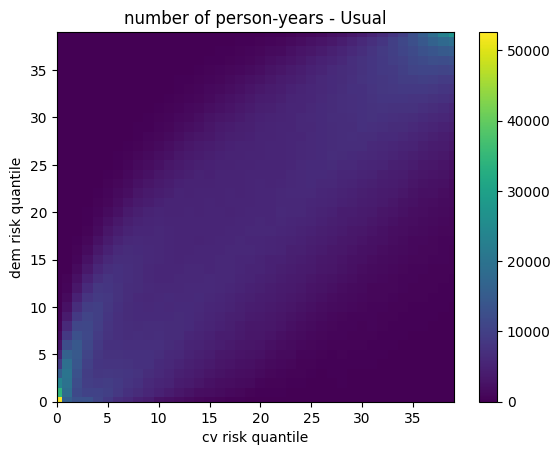

In [38]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByPersonYearsArrayUsual, shading='nearest')
ax.set_title('number of person-years - Usual')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
#set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [36]:
#there are some quantile-quantile boxes where there are exactly 0 person-years
(countByPersonYearsArrayUsual == 0).astype(int).sum()

122

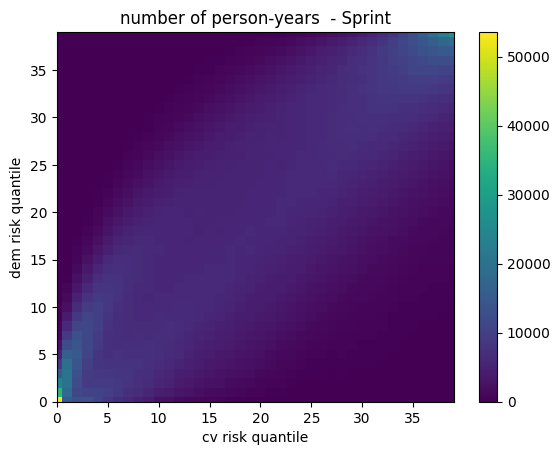

In [39]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByPersonYearsArraySprint, shading='nearest')
ax.set_title('number of person-years  - Sprint')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

<IPython.core.display.Javascript object>


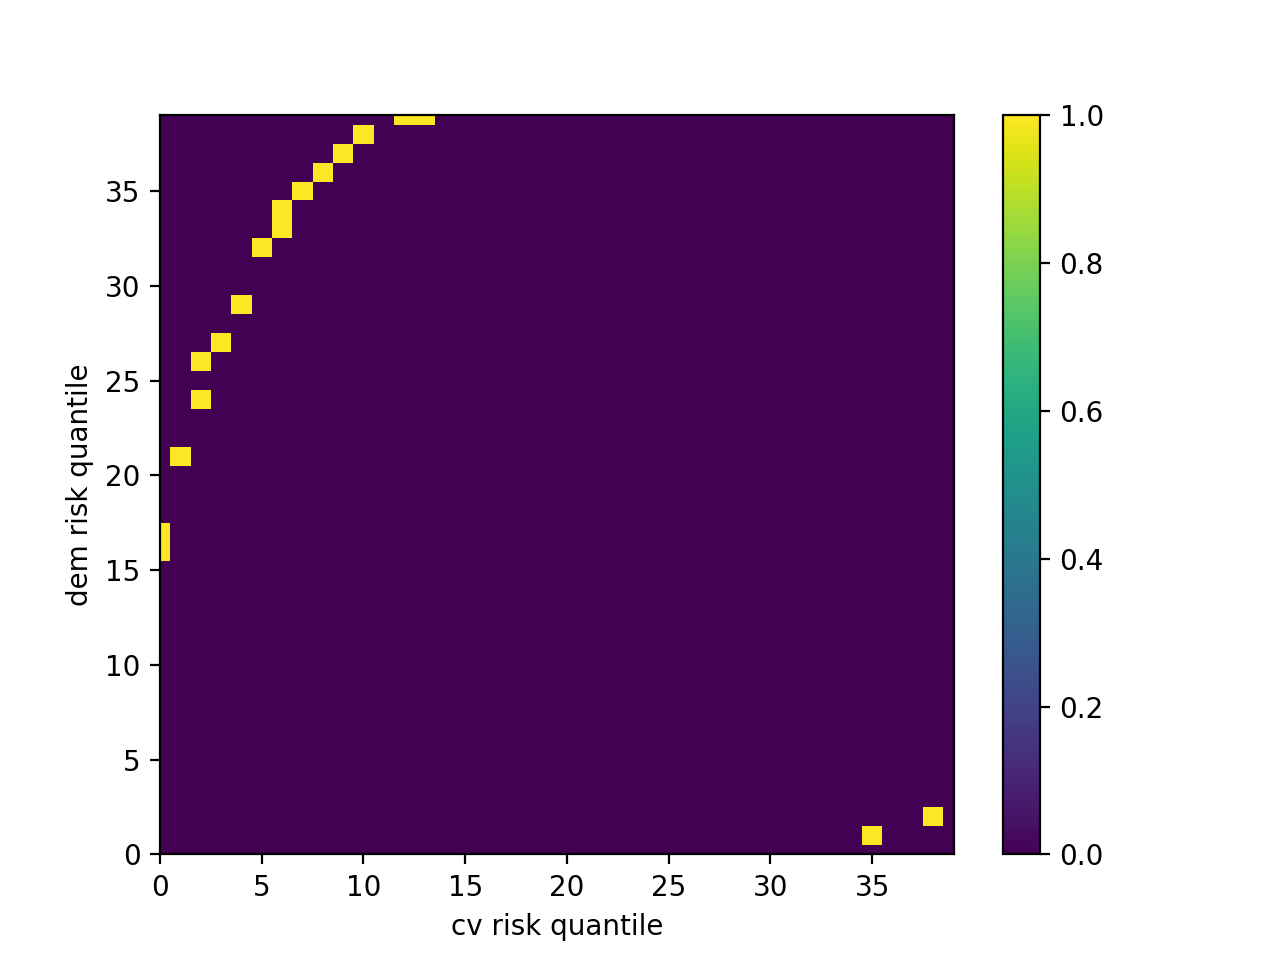

In [83]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, 
                  (countByPersonYearsArraySprint-countByPersonYearsArrayUsual>0) &
                  (countByPersonYearsArrayUsual==0), shading='nearest')
ax.set_title('')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [40]:
#converting to arrays is done to ensure the quantile categories are ordered properly
#find proportion of person-years with dementia
countByDementiaArrayUsual=np.zeros(X.shape)
for i,j,k in zip(countByDementiaDFUsual["demRisk"].values,
                 countByDementiaDFUsual["cvRisk"].values,
                 countByDementiaDFUsual["demCount"].values):
    if countByPersonYearsArrayUsual[i,j]!=0: #cannot divide by 0
        countByDementiaArrayUsual[i,j]=k/countByPersonYearsArrayUsual[i,j] #find proportion
    else:
        countByDementiaArrayUsual[i,j]=0 #this may not be needed, it should be zero if there are 0 person years
        
countByDementiaArraySprint=np.zeros(X.shape)
for i,j,k in zip(countByDementiaDFSprint["demRisk"].values,
                 countByDementiaDFSprint["cvRisk"].values,
                 countByDementiaDFSprint["demCount"].values):
    if countByPersonYearsArraySprint[i,j]!=0: #cannot divide by 0
        countByDementiaArraySprint[i,j]=k/countByPersonYearsArraySprint[i,j] #find proportion
    else:
        countByDementiaArraySprint[i,j]=0 #this may not be needed, it should be zero if there are 0 person years

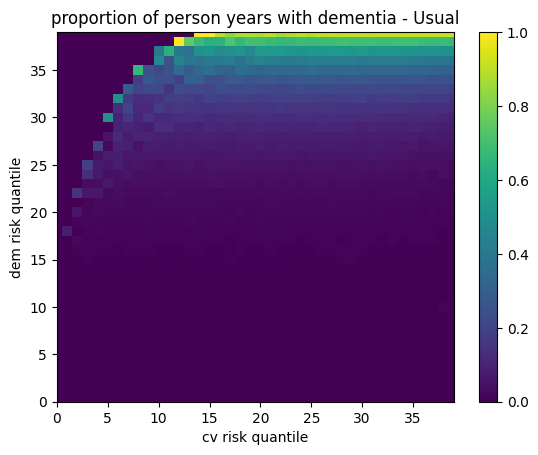

In [41]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByDementiaArrayUsual, shading='nearest')
ax.set_title('proportion of person years with dementia - Usual')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

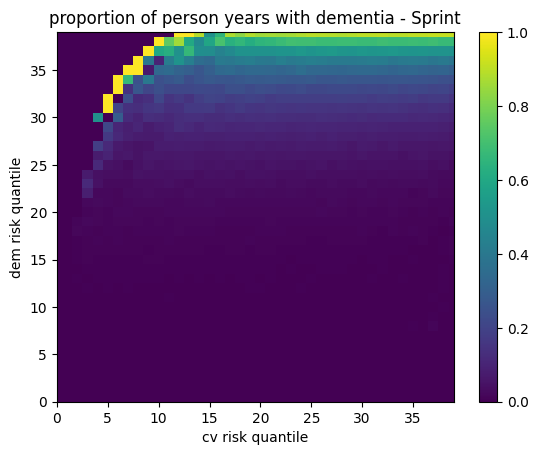

In [42]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByDementiaArraySprint, shading='nearest')
ax.set_title('proportion of person years with dementia - Sprint')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [43]:
#this is done to ensure the quantile categories are ordered properly
#find proportion of person-years with MI
countByMIArrayUsual=np.zeros(X.shape)
for i,j,k in zip(countByMIDFUsual["demRisk"].values,
                 countByMIDFUsual["cvRisk"].values,
                 countByMIDFUsual["miCount"].values):
    if countByPersonYearsArrayUsual[i,j]!=0:
        countByMIArrayUsual[i,j]=k/countByPersonYearsArrayUsual[i,j]
    else:
        countByMIArrayUsual[i,j]=0

countByMIArraySprint=np.zeros(X.shape)
for i,j,k in zip(countByMIDFSprint["demRisk"].values,
                 countByMIDFSprint["cvRisk"].values,
                 countByMIDFSprint["miCount"].values):
    if countByPersonYearsArraySprint[i,j]!=0:
        countByMIArraySprint[i,j]=k/countByPersonYearsArraySprint[i,j]
    else:
        countByMIArraySprint[i,j]=0

In [44]:
#this is done to ensure the quantile categories are ordered properly
#find proportion of person-years with outcome
countByOutcomeArrayUsual=np.zeros(X.shape)
for i,j,k in zip(countByOutcomeDFUsual["demRisk"].values,
                 countByOutcomeDFUsual["cvRisk"].values,
                 countByOutcomeDFUsual["outcomeCount"].values):
    if countByPersonYearsArrayUsual[i,j]!=0:
        countByOutcomeArrayUsual[i,j]=k/countByPersonYearsArrayUsual[i,j]
    else:
        countByOutcomeArrayUsual[i,j]=0

countByOutcomeArraySprint=np.zeros(X.shape)
for i,j,k in zip(countByOutcomeDFSprint["demRisk"].values,
                 countByOutcomeDFSprint["cvRisk"].values,
                 countByOutcomeDFSprint["outcomeCount"].values):
    if countByPersonYearsArraySprint[i,j]!=0:
        countByOutcomeArraySprint[i,j]=k/countByPersonYearsArraySprint[i,j]
    else:
        countByOutcomeArraySprint[i,j]=0

In [45]:
#find differences in outcomes: treatment - no treatment

countByDementiaArrayDiff = (countByDementiaArraySprint-countByDementiaArrayUsual)

countByMIArrayDiff = countByMIArraySprint-countByMIArrayUsual

countByOutcomeArrayDiff = countByOutcomeArraySprint-countByOutcomeArrayUsual

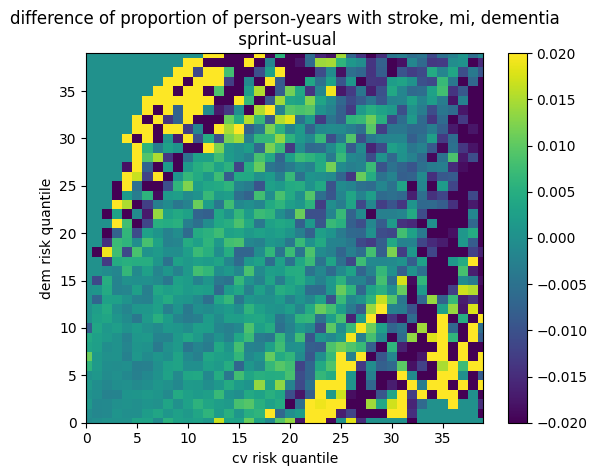

In [46]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByOutcomeArrayDiff, shading='nearest',vmin=-0.02,vmax=0.02)
ax.set_title('difference of proportion of person-years with stroke, mi, dementia\n sprint-usual')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
#noEventCountSum = countByNoEventDFUsual["noEventCount"].sum() #sum of all person-ages
#noEventCountSumPerQbox = noEventCountSum/(nQuantiles)/(nQuantiles) # of person-ages in one qq category, uniform ditribution
#demCountSum, demCountSumPerQbox

#percentCutoffAbsEffectSize = 0.000002 #relevant to a uniform distribution, which qq categories to keep
#cutoffNoEvent = (noEventCountSumPerQbox * percentCutoffAbsEffectSize)
#cutoff

#qqcategoriesToIncludeDementia = countByDementiaDFUsual.loc[countByDementiaDFUsual["demCount"] > cutoffDementia] 
#qqcategoriesToInclude, 
#qqcategoriesToIncludeDementia["demCount"].sum()/demCountSum #percent of person-ages included

# decide on which quantiles to keep
#includedDementia = np.zeros(X.shape)

#for i, j in zip(qqcategoriesToIncludeDementia["demRisk"],qqcategoriesToIncludeDementia["cvRisk"]):
#    includedDementia[i,j]=1
    
#includedBasedOnNoEvent = (countByNoEventArrayDiff>cutoffNoEvent).astype(int)

In [ ]:
# decide on which quantiles to keep
#includedBasedOnPersonYears = np.zeros([nQuantiles,nQuantiles])

#for i, j in zip(quantilesToInclude["demRisk"],quantilesToInclude["cvRisk"]):
#    includedBasedOnPersonYears[i,j]=1

In [ ]:
#included = includedBasedOnPersonYears * includedBasedOnNoEvent

In [ ]:
#fig, ax = plt.subplots()

#c = ax.pcolormesh(X, Y, included, shading='nearest')
#ax.set_title('1.0 for categories to keep, 0 otherwise')
#plt.xlabel("cv risk quantile")
#plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
#ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
#fig.colorbar(c, ax=ax)

#plt.show()

In [47]:
#see if this column name exists before overwriting 
"treatment" in allAgesUsualDF.columns, "sbp" in allAgesUsualDF.columns

(False, True)

In [48]:
#assign boolean variable to treatment column
allAgesUsualDF["treatment"] = 0
allAgesSprintDF["treatment"] = 1

In [49]:
#see if this column name exists before overwriting 
"outcome" in allAgesUsualDF.columns, "sbp" in allAgesUsualDF.columns

(False, True)

In [50]:
#assign boolean variable to outcome column
allAgesUsualDF["outcome"] = ((allAgesUsualDF["mi"]==True) |
                             (allAgesUsualDF["dementia"]==True) |
                             (allAgesUsualDF["stroke"]==True))

allAgesSprintDF["outcome"] = ((allAgesSprintDF["mi"]==True) |
                             (allAgesSprintDF["dementia"]==True) |
                             (allAgesSprintDF["stroke"]==True))

#convert true/false to 1,0
allAgesUsualDF["outcome"] = allAgesUsualDF["outcome"].astype(int)
allAgesSprintDF["outcome"] = allAgesSprintDF["outcome"].astype(int)

In [54]:
quantileIndex = np.arange(nQuantiles*nQuantiles).reshape((nQuantiles,nQuantiles))
quantileIndex.shape

(40, 40)

In [55]:
#see if this column name exists before overwriting 
"quantileIndex" in allAgesUsualDF.columns, "sbp" in allAgesUsualDF.columns

(False, True)

In [56]:
#assign a unique index to each quantile-quantile combination
#while keeping track of the 1-to-1 correspondence
allAgesUsualDF["quantileIndex"] = allAgesUsualDF.apply(
                                                    lambda x: quantileIndex[x["demQuantileNum"],x["cvQuantileNum"]],
                                                    axis=1)

allAgesSprintDF["quantileIndex"] = allAgesSprintDF.apply(
                                                    lambda x: quantileIndex[x["demQuantileNum"],x["cvQuantileNum"]],
                                                    axis=1)

In [57]:
#make dataframe with all regression-related data
regressionData = pd.concat([ allAgesUsualDF[["quantileIndex","treatment","outcome"]],
                             allAgesSprintDF[["quantileIndex","treatment","outcome"]] ])

In [59]:
#save the data just in case
regressionData.to_csv(dataDir+"/regressionData.csv")

In [60]:
#helps with regression
regressionData["treatment"] = regressionData["treatment"]-0.5

In [62]:
md = smf.mixedlm("outcome ~ treatment",regressionData,groups=regressionData["quantileIndex"])
mdf = md.fit()
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: outcome      
No. Observations: 11778277 Method:             REML         
No. Groups:       1496     Scale:              0.0974       
Min. group size:  1        Log-Likelihood:     -3000854.5324
Max. group size:  106138   Converged:          Yes          
Mean group size:  7873.2                                    
-------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept     0.167     0.005   34.491  0.000   0.157   0.176
treatment    -0.002     0.000  -13.047  0.000  -0.003  -0.002
Group Var     0.034     0.004                                



In [63]:
relRiskReduction = mdf.params[1] #slope aka treatment coefficient

In [64]:
groupIntercepts = np.zeros([nQuantiles,nQuantiles])

for i in mdf.random_effects.keys():
    row, column = np.argwhere(quantileIndex==i)[0]
    groupIntercepts[row,column] = mdf.random_effects[i][0] + mdf.params["Intercept"]

In [65]:
absRiskReduction = groupIntercepts * relRiskReduction

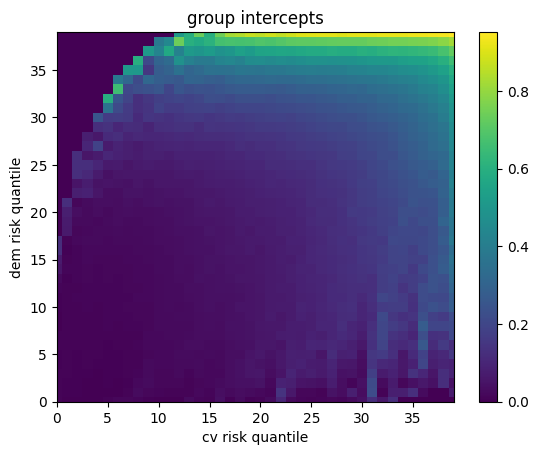

In [66]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, groupIntercepts, shading='nearest') #,vmin=-0.02,vmax=0.02)
ax.set_title('group intercepts')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [74]:
#I do not know why I need to run this to make the next figure interactive
%matplotlib qt 

<IPython.core.display.Javascript object>


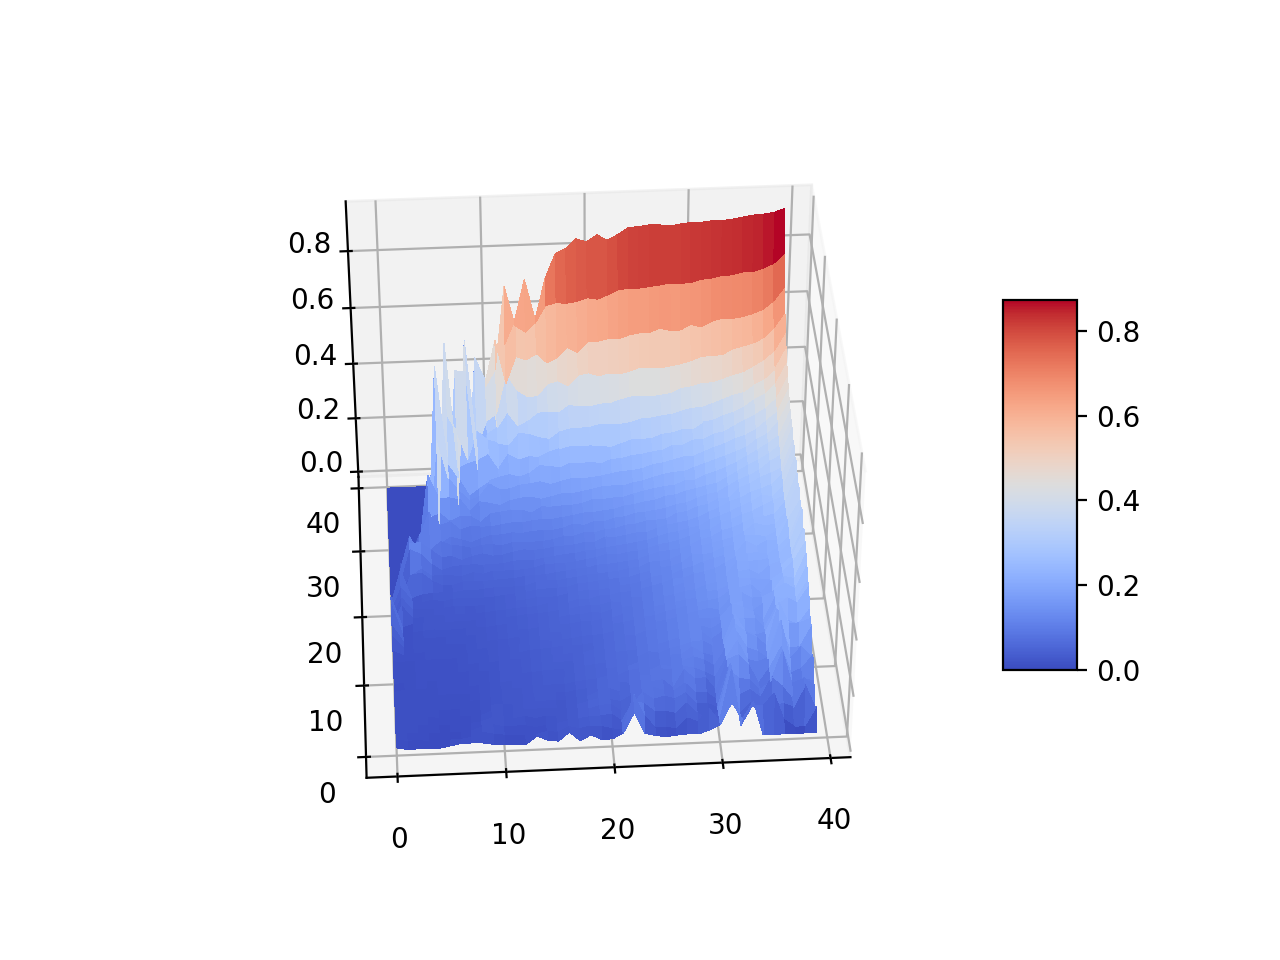

In [75]:
ax = Axes3D(fig)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, groupIntercepts, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
#ax.set_zlim(-0.1, 0.1)
plt.show()

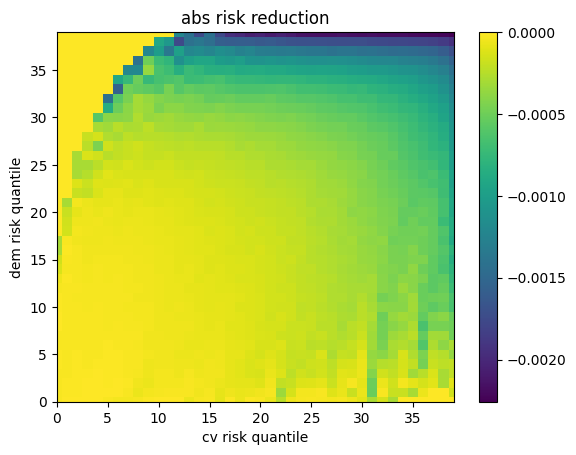

In [67]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, absRiskReduction, shading='nearest') #,vmin=-0.02,vmax=0.02)
ax.set_title('abs risk reduction')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

<IPython.core.display.Javascript object>


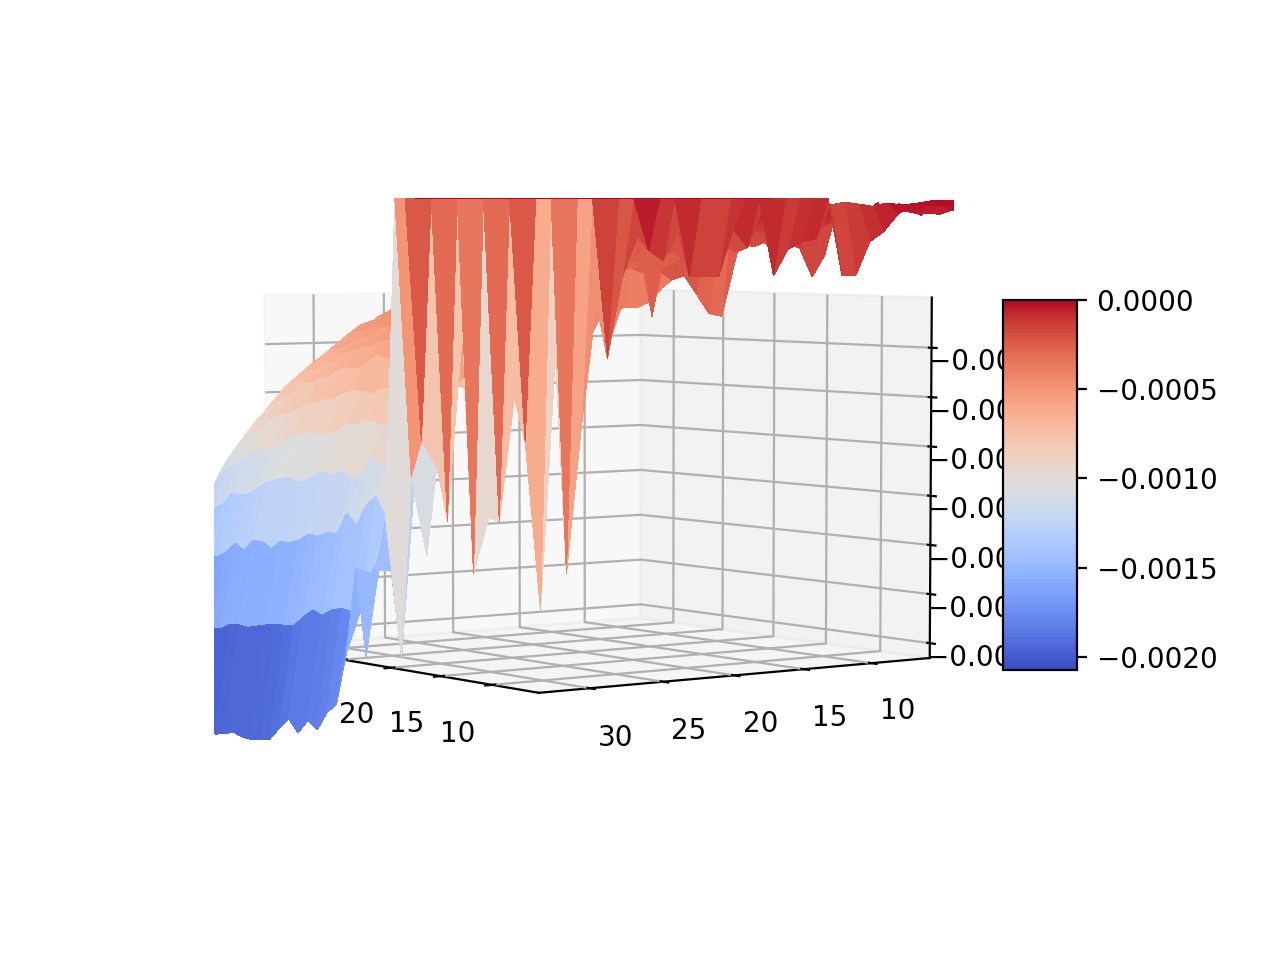

In [76]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, absRiskReduction, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
#ax.set_zlim(-0.1, 0.1)
plt.show()

<IPython.core.display.Javascript object>


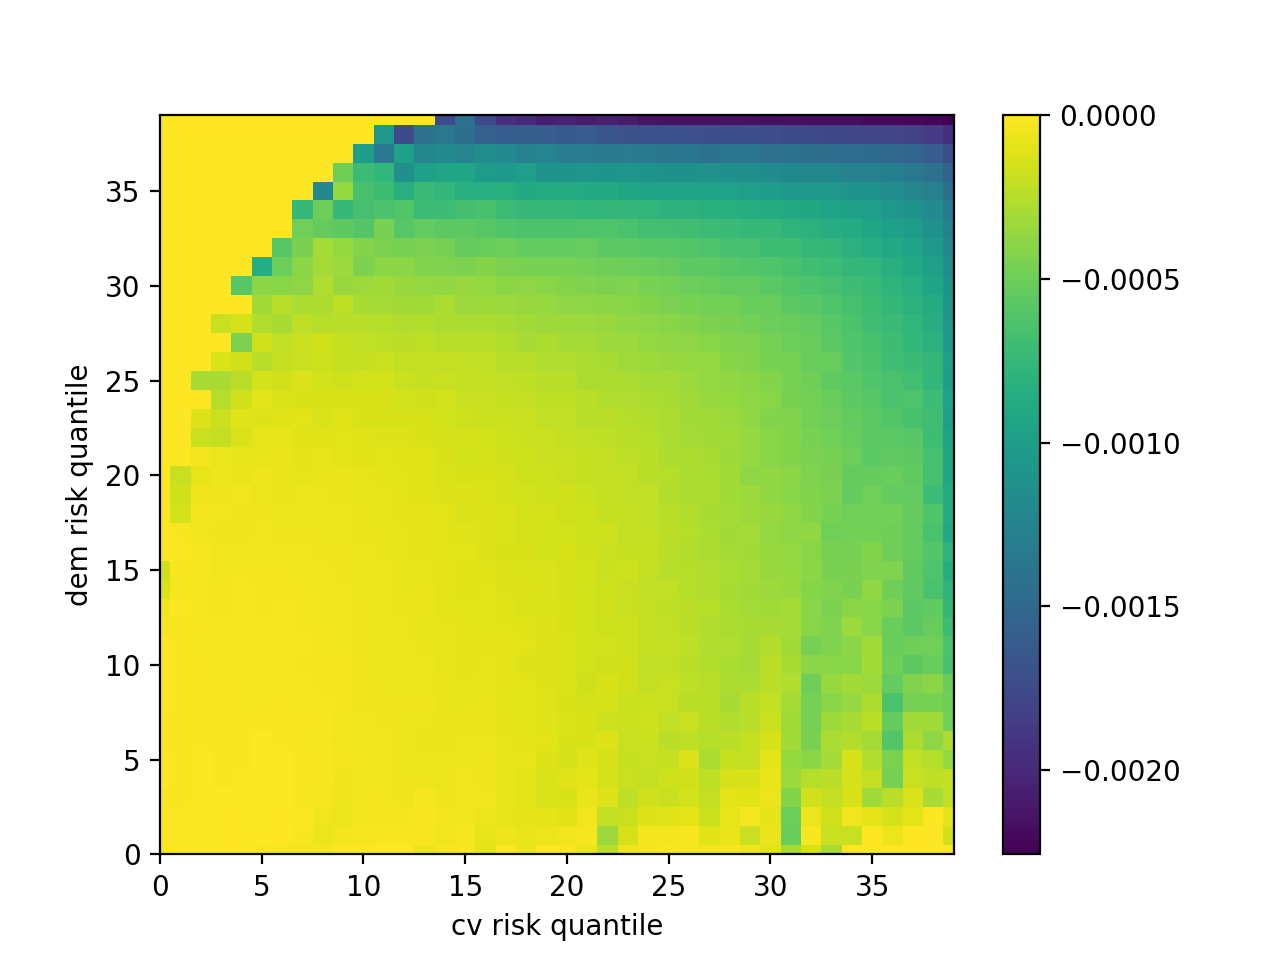

In [84]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, 
                  (~((countByPersonYearsArraySprint-countByPersonYearsArrayUsual>0) &
                  (countByPersonYearsArrayUsual==0))) * absRiskReduction, shading='nearest')
ax.set_title('')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

<IPython.core.display.Javascript object>


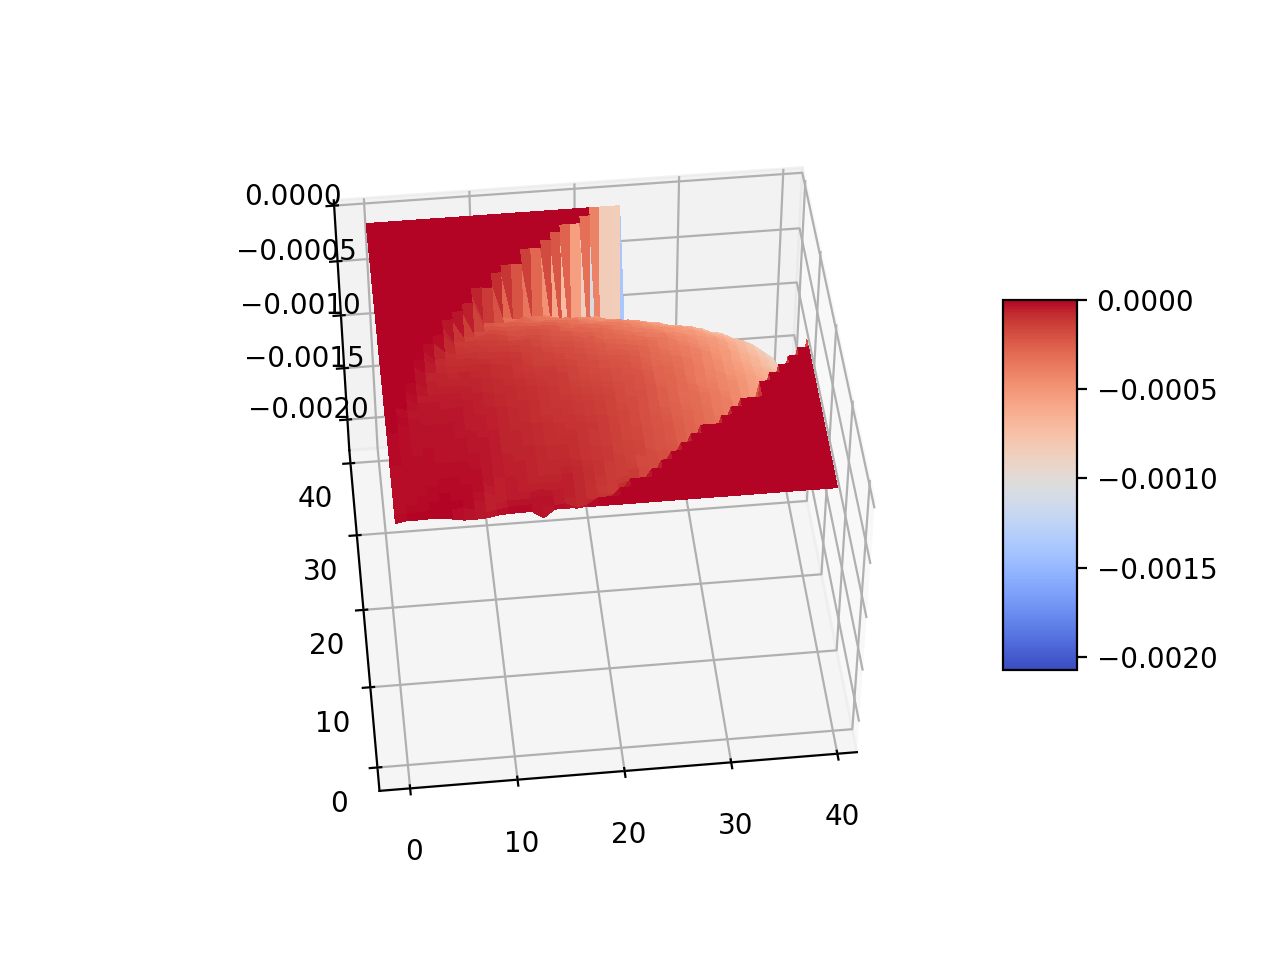

In [87]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, (~(countByPersonYearsArrayUsual<1000)) * absRiskReduction, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
#ax.set_zlim(-0.1, 0.1)
plt.show()

In [68]:
qqIncluded = absRiskReduction < -0.001

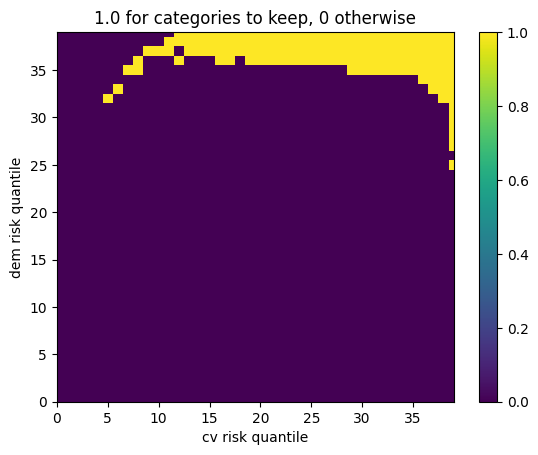

In [69]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, qqIncluded, shading='nearest')
ax.set_title('1.0 for categories to keep, 0 otherwise')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

a different approach now, this one counts events based on people (not person-years)

In [ ]:
#import pickle
#with open(dataDir + "/demQuantileNumberForQuantile.pickle","rb") as file:
#    demQuantileNumberForQuantile=pickle.load(file)
#with open(dataDir + "/cvQuantileNumberForQuantile.pickle","rb") as file:
#    cvQuantileNumberForQuantile=pickle.load(file)

In [ ]:
nQuantiles=quantiles.shape[0]-1
#used in plots later
X=np.arange(0,nQuantiles,1)
Y=np.arange(0,nQuantiles,1)
X, Y = np.meshgrid(X, Y)
X.shape

In [ ]:
cvResultsUsual = popUsual._people.apply(OutcomeAssessor([OutcomeType.MI,OutcomeType.STROKE]).get_outcome)
cvResultsSprint = popSprint._people.apply(OutcomeAssessor([OutcomeType.MI,OutcomeType.STROKE]).get_outcome)

demResultsUsual = popUsual._people.apply(OutcomeAssessor([OutcomeType.DEMENTIA]).get_outcome)
demResultsSprint = popSprint._people.apply(OutcomeAssessor([OutcomeType.DEMENTIA]).get_outcome)

In [ ]:
cvRisksUsual = popUsual._people.apply(
                    OutcomeModelRepository().get_risk_for_person, 
                    args=(OutcomeModelType.CARDIOVASCULAR, 1, False))

demRisksUsual = popUsual._people.apply(
                    OutcomeModelRepository().get_risk_for_person, 
                    args=(OutcomeModelType.DEMENTIA, 1, False))

cvRisksSprint = popSprint._people.apply(
                    OutcomeModelRepository().get_risk_for_person, 
                    args=(OutcomeModelType.CARDIOVASCULAR, 1, False))

demRisksSprint = popSprint._people.apply(
                    OutcomeModelRepository().get_risk_for_person, 
                    args=(OutcomeModelType.DEMENTIA, 1, False))

In [ ]:
resultsUsual = pd.concat([cvRisksUsual,
                          demRisksUsual,
                          cvResultsUsual.astype(int),
                          demResultsUsual.astype(int)],
                         axis=1)

resultsUsual = resultsUsual.rename(columns={0:"cvRisk", 
                                            1:"demRisk",
                                            2:"cv", 
                                            3:"dementia"})
resultsSprint = pd.concat([cvRisksSprint,
                           demRisksSprint,
                           cvResultsSprint.astype(int),
                           demResultsSprint.astype(int)],
                          axis=1)
resultsSprint = resultsSprint.rename(columns={0:"cvRisk", 
                                              1:"demRisk",
                                              2:"cv", 
                                              3:"dementia"})

In [ ]:
resultsUsual.loc[resultsUsual["demRisk"]>1,"demRisk"]=1

In [ ]:
resultsUsual['demRiskQuantile'] = pd.cut(resultsUsual["demRisk"],quantiles["dementia"])
resultsUsual['cvRiskQuantile'] = pd.cut(resultsUsual["cvRisk"],quantiles["cv"])

resultsSprint['demRiskQuantile'] = pd.cut(resultsSprint["demRisk"],quantiles["dementia"])
resultsSprint['cvRiskQuantile'] = pd.cut(resultsSprint["cvRisk"],quantiles["cv"])

In [ ]:
demQuantileNumberForQuantileUsual = {quantile : index for index, quantile in 
                                enumerate(resultsUsual['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileNumberForQuantileUsual = {quantile : index for index, quantile in 
                               enumerate(resultsUsual['cvRiskQuantile'].value_counts(sort=False).index)}

demQuantileNumberForQuantileSprint = {quantile : index for index, quantile in 
                                enumerate(resultsSprint['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileNumberForQuantileSprint = {quantile : index for index, quantile in 
                               enumerate(resultsSprint['cvRiskQuantile'].value_counts(sort=False).index)}

In [ ]:
resultsUsual['cvQuantileNum'] = resultsUsual['cvRiskQuantile']
resultsUsual['cvQuantileNum'].replace(cvQuantileNumberForQuantileUsual, inplace=True)

resultsUsual['demQuantileNum'] = resultsUsual['demRiskQuantile']
resultsUsual['demQuantileNum'].replace(demQuantileNumberForQuantileUsual, inplace=True)

resultsSprint['cvQuantileNum'] = resultsSprint['cvRiskQuantile']
resultsSprint['cvQuantileNum'].replace(cvQuantileNumberForQuantileSprint, inplace=True)

resultsSprint['demQuantileNum'] = resultsSprint['demRiskQuantile']
resultsSprint['demQuantileNum'].replace(demQuantileNumberForQuantileSprint, inplace=True)

In [ ]:
countByDementiaUsual = resultsUsual.loc[resultsUsual["dementia"]==1].groupby(
                                ['cvQuantileNum', 'demQuantileNum'],sort=True
                                )["dementia"].count().unstack(fill_value=0).stack()

countByDementiaDFUsual = pd.DataFrame({'demRisk' : countByDementiaUsual.index.get_level_values(0),
                              'cvRisk' : countByDementiaUsual.index.get_level_values(1),
                              'demCount' : countByDementiaUsual.values})

countByDementiaSprint = resultsSprint.loc[resultsSprint["dementia"]==1].groupby(
                                ['cvQuantileNum', 'demQuantileNum'],sort=True
                                )["dementia"].count().unstack(fill_value=0).stack()

countByDementiaDFSprint = pd.DataFrame({'demRisk' : countByDementiaSprint.index.get_level_values(0),
                              'cvRisk' : countByDementiaSprint.index.get_level_values(1),
                              'demCount' : countByDementiaSprint.values})

In [ ]:
#this is done just in case the quantile categories are not ordered properly
countByDementiaArrayUsual=np.zeros(X.shape)
for i,j,k in zip(countByDementiaDFUsual["demRisk"].values,
                 countByDementiaDFUsual["cvRisk"].values,
                 countByDementiaDFUsual["demCount"].values):
    countByDementiaArrayUsual[i,j]=k

countByDementiaArraySprint=np.zeros(X.shape)
for i,j,k in zip(countByDementiaDFSprint["demRisk"].values,
                 countByDementiaDFSprint["cvRisk"].values,
                 countByDementiaDFSprint["demCount"].values):
    countByDementiaArraySprint[i,j]=k

In [ ]:
countByDementiaArrayDiff = countByDementiaArrayUsual-countByDementiaArraySprint

In [ ]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByDementiaArrayDiff, shading='nearest')
ax.set_title('difference of persons with dementia')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
demCountSum = countByDementiaDFUsual["demCount"].sum() #sum of all person-ages
demCountSumPerQbox = demCountSum/(nQuantiles)/(nQuantiles) # of person-ages in one qq category, uniform ditribution
#demCountSum, demCountSumPerQbox

percentCutoffAbsEffectSize = 0.1 #relevant to a uniform distribution, which qq categories to keep
cutoffDementia = (demCountSumPerQbox * percentCutoffAbsEffectSize)
#cutoff

#qqcategoriesToIncludeDementia = countByDementiaDFUsual.loc[countByDementiaDFUsual["demCount"] > cutoffDementia] 
#qqcategoriesToInclude, 
#qqcategoriesToIncludeDementia["demCount"].sum()/demCountSum #percent of person-ages included

# decide on which quantiles to keep
#includedDementia = np.zeros(X.shape)

#for i, j in zip(qqcategoriesToIncludeDementia["demRisk"],qqcategoriesToIncludeDementia["cvRisk"]):
#    includedDementia[i,j]=1
    
includedDementia = (countByDementiaArrayDiff>cutoffDementia).astype(int)

In [ ]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, includedDementia, shading='nearest')
ax.set_title('1.0 for categories to keep, 0 otherwise')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
anyEvent = LogisticRegressionAnalysis(
                        OutcomeAssessor([
                            OutcomeAssessor.DEATH, 
                            OutcomeType.STROKE, 
                            OutcomeType.MI, 
                            OutcomeType.DEMENTIA, 
                            OutcomeAssessor.CI]))
cogEvent = LogisticRegressionAnalysis(
                        OutcomeAssessor([
                            OutcomeAssessor.CI,
                            OutcomeType.DEMENTIA]))
vascularEventOrDeath = LogisticRegressionAnalysis(
                            OutcomeAssessor([
                                OutcomeAssessor.DEATH, 
                                OutcomeType.STROKE, 
                                OutcomeType.MI]))
#anyEvent = LogisticRegressionAnalysis(OutcomeAssessor([OutcomeAssessor.DEATH, OutcomeType.STROKE, OutcomeType.MI, OutcomeType.DEMENTIA]))
death = LogisticRegressionAnalysis(
                            OutcomeAssessor([
                                OutcomeAssessor.DEATH]))
qalys = LinearRegressionAnalysis(
                            AttributeOutcomeAssessor(
                                "_qalys", AssessmentMethod.SUM))
meanGCP = LinearRegressionAnalysis(
                            AttributeOutcomeAssessor(
                                "_gcp", AssessmentMethod.MEAN))
lastGCP = LinearRegressionAnalysis(
                            AttributeOutcomeAssessor(
                                "_gcp", AssessmentMethod.LAST))

In [ ]:
#results.to_csv("~/Desktop/resultstest.csv")
#results